# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def fmt_items(lines,max_lines=0):
    max_width=max([len(line)for line in lines])
    empty =' '*max_width
    lines = [line.ljust(max_width)for line in lines]
    lines += [empty]*(max_lines - len(lines))
    return lines
    
def pp (*list):
    lines = [ str(item).split('\n') for item in list]
    max_lines=max([len(item)for  item in lines])
    lines = [fmt_items(item,max_lines=max_lines)for item in lines]
    lines_t= np.array(lines).T
    print('\n'.join([' '.join(line) for  line in lines_t]))


In [4]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [6]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [7]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

==GRAD_CHECK== at (0,)  num = 6.000000000039306 anal = 6.0
Gradient check passed!
==GRAD_CHECK== at (0,)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1,)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!
==GRAD_CHECK== at (0, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (0, 1)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 0)  num = 1.0000000000065512 anal = 1.0
==GRAD_CHECK== at (1, 1)  num = 1.0000000000065512 anal = 1.0
Gradient check passed!


True

In [6]:
(array_sum(np.array([5.0, 2.0]))[0]-array_sum(np.array([1.0, 2.0]))[0])/4

1.0

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [7]:
import linear_classifer 
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs)
# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)
# assert np.isclose(probs[0], 1.0)

soft max = [2.06106005e-09 4.53978686e-05 9.99954600e-01]
[2.06106005e-09 4.53978686e-05 9.99954600e-01]
soft max = [1. 0. 0.]
[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [10]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
    
linear_classifer.cross_entropy_loss(probs, np.array(2))


soft max = [4.50940412e-05 6.69254912e-03 9.93262357e-01]


IndexError: too many indices for array

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [ ]:
probs = linear_classifer.softmax(np.array([1, 0, 0]))
linear_classifer.cross_entropy_loss(probs, 0)

In [9]:
loss, grad= linear_classifer.softmax_with_cross_entropy(np.array([1., 0., 0.]), 0)
loss1, grad1= linear_classifer.softmax_with_cross_entropy(np.array([3, 0, 0]), 0)
loss2, grad2 = linear_classifer.softmax_with_cross_entropy(np.array([-1, 0, 0]), 0)
print((loss1-loss2)/4)
print('loss,grad = ',loss, grad)

enter of the function =  [1. 0. 0.] 0
soft max = [0.57611688 0.21194156 0.21194156]


AttributeError: 'int' object has no attribute 'flatten'

In [22]:
# TODO Implement combined function orsoftmax and cross entropy and produces gradient #-2.0491237621641485

check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([ 1,0,0], np.float))

enter of the function =  [1. 0. 0.] 1


AttributeError: 'int' object has no attribute 'flatten'

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
pp('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
pp('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print('predictions =',predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
print('targets = ',target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

predictions = [[ 1.  2. -1.  1.]]
targets =  [[2]]
enter of the function =  [[ 1.  2. -1.  1.]] [[2]]
soft max = [[0.20603191 0.56005279 0.02788339 0.20603191]]
log =  3.5797242232074917
=N_SUMPLES= 1
loss , grand (prediction) =  3.5797242232074917 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]] 
                                                                                                    
enter of the function =  [[ 1.00002  2.      -1.       1.     ]] [[2]]
soft max = [[0.20603518 0.56005049 0.02788327 0.20603106]]
log =  3.5797283438783922
=N_SUMPLES= 1
loss , grand (prediction) =  3.5797283438783922 [[ 0.20603518  0.56005049 -0.97211673  0.20603106]] 
                                                                                                    
enter of the function =  [[ 0.99998  2.      -1.       1.     ]] [[2]]
soft max = [[0.20602864 0.5600551  0.0278835  0.20603276]]
log =  3.5797201026020242
=N_SUMPLES= 1
loss , grand (prediction) =  3.5797201026020242 [[ 0.20

True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [12]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)


loss, dW = linear_classifer.linear_softmax(X, W, target_index)
pp(dW)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

enter of the function =  [[ 1. -1.]  [1 1]
                          [ 0.  3.]]      
soft max = [[0.11245721 0.01521943] 
            [0.0413707  0.83095266]]
log =  4.370364905207625
=N_SUMPLES= 2
loss , grand (prediction) =  2.1851824526038124 [[ 0.11245721 -0.48478057]  
                                                 [ 0.0413707   0.33095266]] 
loss , grand (prediction), grad by W =  2.1851824526038124 [[ 0.11245721 -0.48478057]  [[-0.11245721  0.48478057]  
                                                            [ 0.0413707   0.33095266]]  [-0.07108652  0.81573323]  
                                                                                        [ 0.15382791 -0.15382791]] 
[[-0.11245721  0.48478057] 
 [-0.07108652  0.81573323] 
 [ 0.15382791 -0.15382791]]
enter of the function =  [[ 1. -1.]  [1 1]
                          [ 0.  3.]]      
soft max = [[0.11245721 0.01521943] 
            [0.0413707  0.83095266]]
log =  4.370364905207625
=N_SUMPLES= 2
loss , grand (pr

True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [13]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

enter of L2  (3, 2) 0.01
L2 loss, grad =  0.06 [[ 0.01  0.02] 
                       [-0.01  0.01] 
                       [ 0.01  0.02]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.06 [[ 0.01  0.02] 
                       [-0.01  0.01] 
                       [ 0.01  0.02]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.060000200002 [[ 0.0100002  0.02     ] 
                                 [-0.01       0.01     ] 
                                 [ 0.01       0.02     ]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.059999800002 [[ 0.0099998  0.02     ] 
                                 [-0.01       0.01     ] 
                                 [ 0.01       0.02     ]]
==GRAD_CHECK== at (0, 0)  num = 0.009999999999940612 anal = 0.01
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.06000040000200001 [[ 0.01       0.0200002] 
                                      [-0.01       0.01     ] 
                                      [ 0.01       0.02     ]]
enter of L2  (3, 2) 0.01
L2 loss, grad =  0.0

True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [38]:
# TODO: Implement LinearSoftmaxClassifier.fit function 
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)
'''THERE WERE 10 EPOCHS   !!!!!
'''

loss , grand (prediction) =  11.407754245650851 [[ 1.10183016e-05 -9.99798898e-05  1.10120799e-05 ...  1.11431312e-05 
                                                   1.11880378e-05  1.11244247e-05]                                    
                                                 [ 1.11241086e-05  1.10885994e-05  1.11341011e-05 ...  1.10924594e-05 
                                                   1.10397386e-05  1.10504022e-05]                                    
                                                 [ 1.09393556e-05  1.11736972e-05  1.12084050e-05 ...  1.09764153e-05 
                                                   1.12364555e-05  1.11472021e-05]                                    
                                                 ...                                                                  
                                                 [ 1.09742226e-05  1.12698107e-05  1.11560314e-05 ...  1.10969608e-05 
                                                

enter of L2  (3073, 10) 10.0
Epoch 5, loss: 11.435123
== W == 0.08292656472656296
loss , grand (prediction) =  11.4075183645485 [[ 1.11328122e-05  1.12141167e-05  1.10700323e-05 ...  1.11675649e-05 
                                                 1.11543414e-05  1.11259621e-05]                                    
                                               [ 1.11947479e-05  1.10236702e-05  1.10185994e-05 ...  1.10686638e-05 
                                                 1.11186672e-05  1.11707951e-05]                                    
                                               [ 1.09868224e-05  1.11841283e-05  1.11226431e-05 ...  1.10929740e-05 
                                                 1.10883757e-05  1.10644722e-05]                                    
                                               ...                                                                  
                                               [ 1.10433509e-05  1.11045627e-05  1.09429640e-05 ...

'THERE WERE 10 EPOCHS   !!!!!\n'

[11.438236907928653, 11.43758921489213, 11.436954237927331, 11.43633172400609, 11.435721425194641, 11.435123098549628, 11.434536506016233, 11.433961414328484, 11.43339759491159, 11.432844823786322]


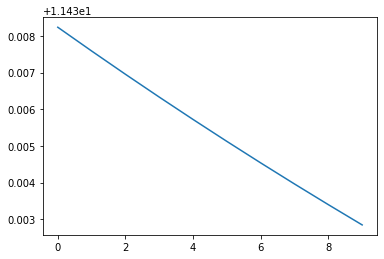

In [39]:
# let's look at the loss history!
print(loss_history)
plt.plot(loss_history)

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [ 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9,1e-10, 1e-11,1e-12,]
reg_strengths = [1e-7, 1e-8, 1e-9,1e-10, 1e-11,]

best_classifier = None
best_val_accuracy = None

data:list = list()

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for l in learning_rates:
    for r in reg_strengths:
        classifier = linear_classifer.LinearSoftmaxClassifier()
        classifier.fit(train_X, train_y, epochs=100, learning_rate=l, batch_size=300, reg=r)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        data.append({'learn rate':l,'regul':r,'accuracy':accuracy})
        


frame = pd.DataFrame(data)
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

# print('best validation accuracy achieved: %f' % best_val_accuracy)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

      learn rate         regul  accuracy
0   1.000000e-04  1.000000e-07     0.089
1   1.000000e-04  1.000000e-08     0.112
2   1.000000e-04  1.000000e-09     0.117
3   1.000000e-04  1.000000e-10     0.081
4   1.000000e-04  1.000000e-11     0.131
5   1.000000e-05  1.000000e-07     0.089
6   1.000000e-05  1.000000e-08     0.123
7   1.000000e-05  1.000000e-09     0.078
8   1.000000e-05  1.000000e-10     0.116
9   1.000000e-05  1.000000e-11     0.102
10  1.000000e-06  1.000000e-07     0.083
11  1.000000e-06  1.000000e-08     0.088
12  1.000000e-06  1.000000e-09     0.108
13  1.000000e-06  1.000000e-10     0.107
14  1.000000e-06  1.000000e-11     0.091
15  1.000000e-07  1.000000e-07     0.112
16  1.000000e-07  1.000000e-08     0.092
17  1.000000e-07  1.000000e-09     0.113
18  1.000000e-07  1.000000e-10     0.131
19  1.000000e-07  1.000000e-11     0.094
20  1.000000e-08  1.000000e-07     0.096
21  1.000000e-08  1.000000e-08     0.110
22  1.000000e-08  1.000000e-09     0.101
23  1.000000e-08

Text(0.5, 0, 'accuracy')

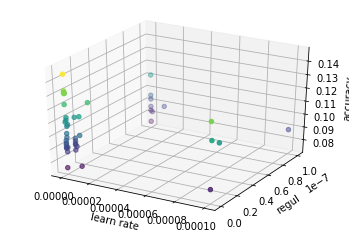

In [34]:
print(frame)
ax=plt.subplot(projection = '3d')
ax.scatter(frame['learn rate'],frame['regul'],frame['accuracy'],c = frame['accuracy'],cmap = 'viridis')
ax.set_xlabel('learn rate')
ax.set_ylabel('regul')
ax.set_zlabel('accuracy')

     learn rate    regul  accuracy
0  1.000000e-01  0.00001     0.088
1  1.000000e-02  0.00001     0.090
2  1.000000e-03  0.00001     0.083
3  1.000000e-04  0.00001     0.084
4  1.000000e-05  0.00001     0.084
5  1.000000e-06  0.00001     0.094
6  1.000000e-07  0.00001     0.100
7  1.000000e-08  0.00001     0.076
8  1.000000e-09  0.00001     0.136


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

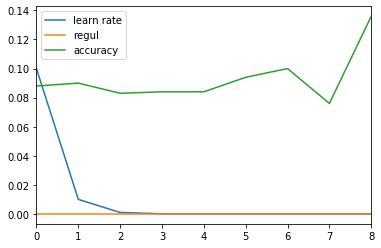

In [17]:
print(frame)
frame.plot()
plt.set_ylim(0,30)

     learn rate    regul  accuracy
0  1.000000e-01  0.00001     0.088
1  1.000000e-02  0.00001     0.090
2  1.000000e-03  0.00001     0.083
3  1.000000e-04  0.00001     0.084
4  1.000000e-05  0.00001     0.084
5  1.000000e-06  0.00001     0.094
6  1.000000e-07  0.00001     0.100
7  1.000000e-08  0.00001     0.076
8  1.000000e-09  0.00001     0.136


(0, 0.3)

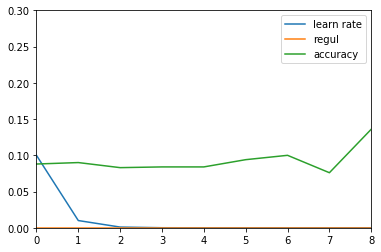

In [19]:
print(frame)
frame.plot()
axes = plt.gca()
axes.set_ylim(0,0.3)

In [23]:
test_class = linear_classifer.LinearSoftmaxClassifier()
test_pred = test_class.pred_rand(val_X)
accuracy = multiclass_accuracy(test_pred, val_y)
print(accuracy)

0.096


# Какой же точности мы добились на тестовых данных?

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

AttributeError: 'NoneType' object has no attribute 'predict'

In [18]:
np.__version__

'1.17.0'